<div style="background:#6689b3;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 5px;font-weight:bold">
    <strong>
        <h1 style = "color:#fff">SKELETON BASED ACTION RECOGNITION</h1>
    </strong>
</div>

<h3>Problem Statement</h3>
<p>To Develop and Evaluate a machine learning model for a 3D skeleton-based action recognition system using UTD MHAD dataset. </p>

![image.png](attachment:image.png)

<h3>Feature Extraction</h3>
<p>To Calculate the  Euclidean distance  between Shoulder center joint to remaining all joints.</p>

<div style="background:#6689b3;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 5px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff">1 | Importing the Required Packages</h4>
    </strong>
</div>

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from pycaret.classification import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

<div style="background:#6689b3;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 5px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff">2 | Read data from mat files & splitting test and train data</h4>
    </strong>
</div>

In [ ]:
train = []
test = []
dataDir = "./Skeleton/"
for file in os.listdir(dataDir):
    if file.endswith(".mat"):
        if "s2" in file or "s4" in file or "s6" in file or "s8" in file:
            train.append([loadmat(dataDir+file)["d_skel"],file.split("_")[0]])
        else:
            test.append([loadmat(dataDir+file)["d_skel"],file.split("_")[0]])

<div style="background:#6689b3;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 5px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff">3 | Trimming the frames </h4>
    </strong>
</div>

In [ ]:
def trim(x,minvalue):
    r = (x.shape[2]/(minvalue) )
    array = []
    t=0+r
    i=int(t)
    # print(x.shape[2])
    while i+1 < x.shape[2]:
        array.append( x[:,:,i] + ( (x[:,:,i] - x[:,:,i+1])*(t-i) )  )
        t+=r
        i=int(t)-1
    return np.array(array)[:40].transpose(1,2,0)

In [ ]:
print(test[-1][0].shape)
print(trim(test[-1][0],41).shape)

(20, 3, 74)
(20, 3, 40)


<div style="background:#6689b3;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 5px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff">4 | Euclidean distance from shoulder center to joint points</h4>
    </strong>
</div>

Function to find euclidean distance from shoulder center to all the joints

![image.png](attachment:image.png)

In [ ]:
d = lambda x1,y1,z1,x2,y2,z2 : ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)**0.5
def dist_func(skl):
    dvals = d(skl[:,0,:],skl[:,1,:],skl[:,2,:],skl[1,0,:],skl[1,1,:],skl[1,2,:])
    dvals = (dvals[:]-dvals.mean())/dvals.std()
    return dvals

<h3>Finding the euclidean distance using manual method</h3><br>
storing the x, y and z of all the joint points of first frame

In [ ]:
x = train[0][0][:,0,0]
y = train[0][0][:,1,0]
z = train[0][0][:,2,0]

euclidean distance from shoulder center to all other joint points

In [ ]:
d(x,y,z,x[1],y[1],z[1])

array([0.18737894, 0.        , 0.3375911 , 0.40064118, 0.19117409,
       0.41033581, 0.61674484, 0.67288064, 0.19073015, 0.42157014,
       0.62030849, 0.66694728, 0.47689756, 0.87298177, 1.18538134,
       1.24451119, 0.4745527 , 0.88795728, 1.18851692, 1.24497871])

<h3>Finding the euclidean distance using dist_func (numpy slicing and lambda mapping)</h3><br>
storing the x, y and z of all the joint points of first frame

In [ ]:
np.array([dist_func(train[0][0])[i][0] for i in range(20)])

array([-1.11345107, -1.60632262, -0.71834103, -0.55249747, -1.10346851,
       -0.52699723,  0.01593005,  0.16358664, -1.10463624, -0.49744705,
        0.02530367,  0.14797986, -0.35191676,  0.68992195,  1.5116411 ,
        1.66717308, -0.35808455,  0.72931275,  1.51988875,  1.66840282])

<div style="background:#6689b3;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 5px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff">5 | Finding the distance for the values stored in train and test dataset</h4>
    </strong>
</div>

In [ ]:
def return_distance_and_action(mats):
    x = []
    y = []
    for skl in mats:
        x.append(dist_func(trim(skl[0],41)).flatten())
        y.append(skl[1])
    return np.array(x),np.array(y)

In [ ]:
X_train,y_train = return_distance_and_action(train)
X_test,y_test = return_distance_and_action(test)

<div style="background:#6689b3;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 5px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff">6 | Data Modelling using classification algorithms</h4>
    </strong>
</div>

<h3>Logistic Regression</h3>

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Accuracy: ",(accuracy_score(y_test, y_pred)))

Accuracy:  0.6751740139211136


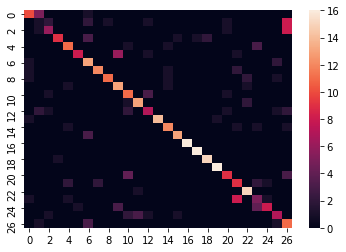

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred))

<h3>KNN</h3>

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))

Accuracy:  0.5986078886310905


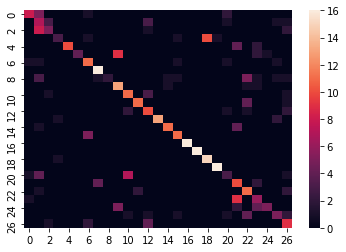

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred))

<h3>Multinomial Naive Bayes</h3>

In [ ]:
mnb = MultinomialNB()
ms = MinMaxScaler()
mnb.fit(ms.fit_transform(X_train), y_train)
y_pred = mnb.predict(ms.fit_transform(X_test))
print("Accuracy: ",accuracy_score(y_test,y_pred))

Accuracy:  0.5870069605568445


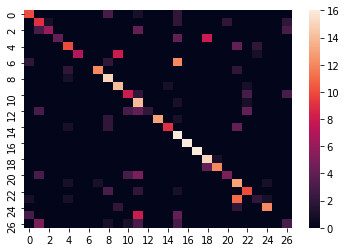

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred))

<h3>Gaussian Naive Bayes</h3>

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))

Accuracy:  0.5707656612529002


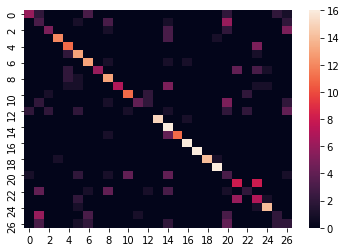

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred))

<h3>XGBoost Classifier</h3>

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))

[20:16:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.5220417633410673


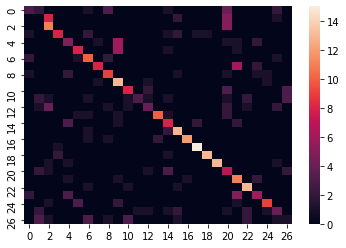

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred))

<h3>ExtraTrees Classifier</h3>

In [ ]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))

Accuracy:  0.6705336426914154


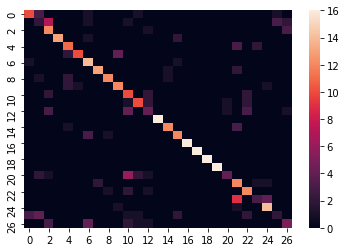

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred))

<h3>Decision Tree Classifier</h3>

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))

Accuracy:  0.38979118329466356


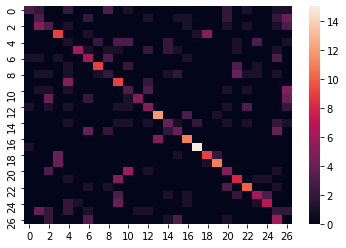

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred))

<h3>LightGBM Classifier</h3>

In [ ]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred))

<div style="background:#6689b3;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 5px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff">7 | Conclusion</h4>
    </strong>
</div>

<p>We have successfully implemented <strong>skeleton based action recognition</strong> using data preprocessing techniques for feature extraction by converting all the <strong>d_skel data stored in the .mat files into 1-D array </strong> and finally building a <strong>classification models</strong> using machine learning techniques</p>